# 1. Carregamento das bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

# 2. Exploração dos dados

Este capítulo do Notebook apresenta como foram tratados os dados para posterior análise.

## 2.1. Conhecendo o DF, prévia e tipo dos dados

In [4]:
#Conhecendo o DF
df= pd.read_csv('dados_finais.csv')

print('shape:', df.shape)


shape: (5565, 47)


In [5]:
#Conhecendo uma prévia dos dados
df.head(10)

,ID,COD_UF,UF,REGIAO,NOMEMUN,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RFE,RER,DEM,OPNV,IMH,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
0,1100015,11,RO,Norte,ALTA FLORESTA D'OESTE,0.707630,24392,3.45,1.8,3271.0,14.1,41.8,95.7,6.2,4.8,19611.75,88.0,61193.26,63500.28,14.12,4.2,7067025.00,2.6,36.5,0.4,70.75,5.84,8.67,11.99,0.58,14.29,26.04,47.12,476.99,93.69,22.58,94.05,93.98,12656,11736,10611,10422,13970,0.641,0.526,0.763,0.657
1,1100023,11,RO,Norte,ARIQUEMES,0.751337,90353,20.41,2.0,19886.0,18.7,35.0,97.2,5.5,4.9,21389.67,66.2,235252.82,198489.65,13.34,1.2,4426571.00,8.6,33.8,5.1,73.36,4.36,9.18,7.90,0.53,4.36,11.54,29.04,689.95,98.54,27.15,96.72,98.58,45543,44810,45300,13828,76525,0.702,0.600,0.806,0.716
2,1100031,11,RO,Norte,CABIXI,0.755332,6313,4.80,1.8,607.0,11.2,41.4,98.1,6.1,5.1,22315.80,91.4,21441.70,19269.95,NaN,6.5,1314352.00,22.1,1.0,0.0,70.39,6.87,10.09,13.63,0.51,7.27,21.20,46.98,457.17,95.49,19.93,99.14,96.36,3266,3047,2869,3620,2693,0.650,0.559,0.757,0.650
3,1100049,11,RO,Norte,CACOAL,0.751092,78574,20.72,2.0,19942.0,23.5,35.6,97.6,6.3,5.1,24037.91,67.4,178701.03,172804.94,9.64,1.0,3792892.00,52.5,86.6,11.7,74.27,5.57,9.74,8.29,0.57,5.97,13.08,29.82,738.06,97.96,20.50,98.17,98.89,39124,39450,40083,16653,61921,0.718,0.620,0.821,0.727
4,1100056,11,RO,Norte,CEREJEIRAS,0.750303,17029,6.12,2.0,2482.0,15.1,35.7,98.5,6.4,5.3,25009.71,87.6,48054.32,42293.05,3.61,7.5,2783.30,17.1,36.2,2.0,72.94,6.44,10.22,10.29,0.50,4.72,13.70,34.85,577.18,97.53,16.66,91.89,98.85,8551,8478,8699,2610,14419,0.692,0.602,0.799,0.688
5,1100064,11,RO,Norte,COLORADO DO OESTE,0.726231,18591,12.81,1.8,2401.0,14.8,37.0,97.6,6.4,5.0,18413.74,88.7,40127.82,37280.76,20.58,6.6,1451.06,5.2,10.7,4.1,73.81,7.51,10.40,12.43,0.49,6.64,15.76,37.11,535.41,95.54,14.73,92.79,97.76,9330,9261,8851,4934,13657,0.685,0.584,0.814,0.676
6,1100072,11,RO,Norte,CORUMBIARA,0.748215,8783,2.87,1.9,860.0,11.4,42.4,97.1,5.7,4.4,38156.05,92.8,31010.24,25701.31,22.99,1.0,3060321.00,11.3,56.2,0.5,71.45,5.67,9.82,12.47,0.48,10.16,24.02,46.42,402.15,93.24,14.46,90.19,97.81,4711,4072,4251,6193,2590,0.613,0.473,0.774,0.630
7,1100080,11,RO,Norte,COSTA MARQUES,0.732188,13678,2.74,1.8,996.0,5.6,44.3,97.6,4.8,5.0,12413.35,94.6,33459.88,24663.36,32.41,0.5,4987177.00,8.3,44.8,0.0,70.04,3.82,9.22,8.60,0.52,9.66,30.48,55.80,370.77,95.67,36.18,79.35,90.13,7202,6476,6266,6181,7497,0.611,0.493,0.751,0.616
8,1100098,11,RO,Norte,ESPIGÃO D'OESTE,0.754812,28729,6.36,1.9,5301.0,16.5,39.7,95.9,6.1,5.2,17498.71,75.6,70983.61,56572.26,7.50,4.0,4518038.00,13.7,59.4,4.2,74.15,5.21,9.55,11.33,0.52,6.60,13.86,35.08,590.80,93.70,19.97,91.07,96.70,14606,14123,15107,8119,20610,0.672,0.536,0.819,0.691
9,1100106,11,RO,Norte,GUAJARÁ-MIRIM,0.762954,41656,1.68,2.0,4504.0,9.8,41.4,93.1,4.9,4.4,16955.80,82.6,85114.29,75732.45,21.38,5.0,24855724.00,20.5,15.2,3.1,74.39,4.82,8.17,8.06,0.54,10.38,23.47,43.92,494.69,93.26,43.40,90.41,97.71,20947,20709,16920,6449,35207,0.657,0.519,0.823,0.663


In [6]:
#Setando o ID como index do DF
df.set_index('ID', inplace=True, drop=True)

In [7]:
#checando os nomes das colunas
df.columns 

Index(['COD_UF', 'UF', 'REGIAO', 'NOMEMUN', 'SCO', 'TPM', 'DDM', 'SMM', 'POM',
       'TPO', 'RSA', 'TXE', 'IDEBI', 'IDEBF', 'PIB', 'RFE', 'RER', 'DEM',
       'OPNV', 'IMH', 'AUT', 'ESA', 'AVP', 'UVP', 'ESPVIDA', 'T_ENV',
       'E_ANOSESTUDO', 'T_ANALF15M', 'GINI', 'PIND', 'PMPOB', 'PPOB', 'RDPC',
       'T_AGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'HOMEMTOT', 'MULHERTOT', 'PEA',
       'pesoRUR', 'pesourb', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R'],
      dtype='object')

In [8]:
#checando os tipos dos dados
df.dtypes

COD_UF            int64
UF               object
REGIAO           object
NOMEMUN          object
SCO             float64
TPM               int64
DDM             float64
SMM             float64
POM             float64
TPO             float64
RSA             float64
TXE             float64
IDEBI           float64
IDEBF           float64
PIB             float64
RFE             float64
RER             float64
DEM             float64
OPNV            float64
IMH             float64
AUT             float64
ESA             float64
AVP             float64
UVP             float64
ESPVIDA         float64
T_ENV           float64
E_ANOSESTUDO    float64
T_ANALF15M      float64
GINI            float64
PIND            float64
PMPOB           float64
PPOB            float64
RDPC            float64
T_AGUA          float64
T_DENS          float64
T_LIXO          float64
T_LUZ           float64
HOMEMTOT          int64
MULHERTOT         int64
PEA               int64
pesoRUR           int64
pesourb         

In [9]:
df.describe()

,COD_UF,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RFE,RER,DEM,OPNV,IMH,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
count,5565.000000,5565.000000,5.565000e+03,5565.000000,5565.000000,5.565000e+03,5565.000000,5565.000000,5565.000000,5473.000000,5458.000000,5565.000000,4997.000000,5.565000e+03,5.565000e+03,4149.000000,5115.000000,5.565000e+03,5565.000000,5551.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,5.565000e+03,5.565000e+03,5.565000e+03,5565.000000,5.565000e+03,5565.000000,5565.000000,5565.000000,5565.000000
mean,32.372327,0.748560,3.427777e+04,108.202577,2.017934,9.382440e+03,15.296406,40.743863,97.137233,5.598812,4.379058,21979.495614,85.481369,1.127160e+05,1.020636e+05,17.370357,2.500391,1.382316e+06,41.844420,67.890650,17.077484,73.088996,8.397333,9.463639,16.158898,0.494381,11.341416,23.206573,43.990789,493.605617,85.598029,25.126600,94.047324,97.189614,1.678472e+04,1.749305e+04,1.686272e+04,5360.288769,2.891748e+04,0.659157,0.559094,0.801564,0.642873
std,9.829957,0.036039,2.031126e+05,572.117006,0.484922,9.340953e+04,10.435908,10.264519,2.665811,1.014320,0.791632,20917.026242,11.124204,8.760865e+05,8.402942e+05,13.434068,4.358700,5.462701e+06,31.222152,26.912599,18.837519,2.680715,2.422997,1.098269,9.839618,0.066075,11.764060,17.915650,22.437971,243.269333,14.721327,12.998503,11.049525,6.024377,9.610372e+04,1.070224e+05,1.070601e+05,6641.675014,2.015510e+05,0.071997,0.093328,0.044681,0.080662
min,11.000000,0.487972,8.050000e+02,0.130000,0.800000,5.900000e+01,1.000000,12.200000,51.800000,2.700000,1.900000,3285.040000,0.100000,0.000000e+00,7.463100e+02,1.600000,0.000000,2.610000e+01,0.000000,0.200000,0.000000,65.300000,1.460000,4.340000,0.950000,0.280000,0.000000,0.000000,1.970000,96.250000,0.150000,0.650000,0.000000,27.410000,4.220000e+02,3.830000e+02,3.070000e+02,0.000000,1.740000e+02,0.418000,0.207000,0.672000,0.400000
25%,25.000000,0.733116,5.235000e+03,11.570000,1.700000,5.640000e+02,7.800000,32.500000,96.600000,4.800000,3.800000,9476.580000,80.500000,1.881977e+04,1.663053e+04,10.100000,0.400000,1.537760e+05,12.500000,49.200000,1.800000,71.150000,6.780000,8.750000,8.080000,0.450000,1.640000,7.030000,23.960000,281.120000,79.650000,15.410000,93.720000,97.650000,2.671000e+03,2.574000e+03,2.386000e+03,1599.000000,2.839000e+03,0.599000,0.490000,0.769000,0.572000
50%,31.000000,0.754317,1.093400e+04,24.380000,1.900000,1.233000e+03,12.500000,39.700000,97.600000,5.700000,4.400000,16598.420000,88.700000,3.238398e+04,2.901840e+04,14.290000,1.000000,3.520250e+05,37.300000,74.900000,10.200000,73.470000,8.380000,9.470000,13.120000,0.490000,6.240000,18.140000,42.230000,467.650000,90.280000,23.070000,98.030000,99.390000,5.548000e+03,5.419000e+03,4.933000e+03,3233.000000,6.263000e+03,0.665000,0.560000,0.808000,0.654000
75%,41.000000,0.773103,2.342400e+04,51.670000,2.200000,3.536000e+03,19.700000,50.100000,98.500000,6.400000,5.000000,27051.850000,93.700000,6.515173e+04,5.801804e+04,20.410000,2.700000,9.090390e+05,69.800000,91.200000,27.100000,75.160000,9.960000,10.210000,24.320000,0.540000,19.060000,38.520000,65.300000,650.620000,96.260000,32.580000,99.490000,99.870000,1.175800e+04,1.170700e+04,1.061400e+04,6767.000000,1.548400e+04,0.718000,0.631000,0.836000,0.707000
max,53.000000,0.850899,1.125350e+07,13024.560000,6.500000,5.571893e+06,133.500000,70.100000,100.000000,9.100000,7.200000,344847.170000,100.000000,5.401100e+07,5.141403e+07,285.710000,80.800000,1.595333e+08,100.000000,100.000000,98.300000,78.640000,20.420000,12.830000,44.400000,0.800000,69.670000,78.590000,91.570000,2043.740000,100.000000,88.640000,100.000000,100.000000,5.328632e+06,5.924871e+06,6.026212e+06,125336.000000,1.115234e+07,0.862000,0.825000,0.894000,0.891000


## 2.2. Verificação de dados duplicados, checagens e tratamentos

In [10]:
# Verificando se há dados de index duplicados
df[df.index.duplicated()==True]

,COD_UF,UF,REGIAO,NOMEMUN,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RFE,RER,DEM,OPNV,IMH,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [11]:
#validando se o número total de homens+mulheres bate com o total da população
df[(df['HOMEMTOT']+df['MULHERTOT']) !=df['TPM']]

,COD_UF,UF,REGIAO,NOMEMUN,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RFE,RER,DEM,OPNV,IMH,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [12]:
#verificando se as colunas da raspagem de dados há dados duplicados:
colunas=['TPM', 'DDM', 'SMM',
       'POM', 'TPO', 'RSA', 'TXE', 'IDEBI', 'IDEBF', 'PIB', 'RFE', 'RER',
       'DEM', 'OPNV', 'IMH', 'AUT', 'ESA', 'AVP', 'UVP']
df[df.duplicated(colunas)==True]

,COD_UF,UF,REGIAO,NOMEMUN,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RFE,RER,DEM,OPNV,IMH,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Não foram verificados dados duplicados e/ou discrepantes entre as bases pesquisadas (Atlas Brasil e IBGE).

## 2.3. Verificação de dados faltantes

In [13]:
#verificando dados faltantes (por atributo)
nulos=df.isna().sum()

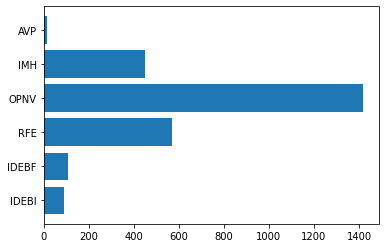

In [14]:
plt.barh(nulos[nulos>0].index,nulos[nulos>0])
plt.show()

In [15]:
print(nulos[nulos>0])

IDEBI      92
IDEBF     107
RFE       568
OPNV     1416
IMH       450
AVP        14
dtype: int64


In [16]:
#Total de registros faltantes no dataset
df.isna().sum().sum()

2647

Como alguns atributos apresentaram altas taxas de dados faltantes, optou-se por exclui-los do dataset ao invés de preenchê-los com a média ou moda para não criar vieses. Sendo assim, os atributos "OPNV", "RFE" e "IMH" foram retirados do dataset:

In [17]:
df_original=df.copy()

df.drop(columns=['OPNV','RFE','IMH'], inplace=True)

Para os demais dados faltantes, o procedimento realizado foi o preenchimento de acordo com a média dos valores de cada atributos.

In [18]:
#preenchendo os dados faltantes com a média dos valores:
df.fillna(df.mean(),inplace=True)

In [19]:
print("Total de dados faltantes após o tratamento:", df.isna().sum().sum())
print(df.isna().sum())

Total de dados faltantes após o tratamento: 0
COD_UF          0
UF              0
REGIAO          0
NOMEMUN         0
SCO             0
TPM             0
DDM             0
SMM             0
POM             0
TPO             0
RSA             0
TXE             0
IDEBI           0
IDEBF           0
PIB             0
RER             0
DEM             0
AUT             0
ESA             0
AVP             0
UVP             0
ESPVIDA         0
T_ENV           0
E_ANOSESTUDO    0
T_ANALF15M      0
GINI            0
PIND            0
PMPOB           0
PPOB            0
RDPC            0
T_AGUA          0
T_DENS          0
T_LIXO          0
T_LUZ           0
HOMEMTOT        0
MULHERTOT       0
PEA             0
pesoRUR         0
pesourb         0
IDHM            0
IDHM_E          0
IDHM_L          0
IDHM_R          0
dtype: int64


In [20]:
#Descrição da coluna de Score (GGI):
df['SCO'].describe()

count    5565.000000
mean        0.748560
std         0.036039
min         0.487972
25%         0.733116
50%         0.754317
75%         0.773103
max         0.850899
Name: SCO, dtype: float64

## 2.5. Padronização dos dados

Com um dataset composto por diversos atributos de diferentes grandezas, outro tratamento necessário é a padronização dos dados. A padronização foi realizada em uma parte do dataset, que desconsidera os atributos categóricos.

In [21]:
df.iloc[:,4:]

,SCO,TPM,DDM,SMM,POM,TPO,RSA,TXE,IDEBI,IDEBF,PIB,RER,DEM,AUT,ESA,AVP,UVP,ESPVIDA,T_ENV,E_ANOSESTUDO,T_ANALF15M,GINI,PIND,PMPOB,PPOB,RDPC,T_AGUA,T_DENS,T_LIXO,T_LUZ,HOMEMTOT,MULHERTOT,PEA,pesoRUR,pesourb,IDHM,IDHM_E,IDHM_L,IDHM_R
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1100015,0.707630,24392,3.45,1.8,3271.0,14.1,41.8,95.7,6.2,4.8,19611.75,61193.26,63500.28,7067025.0,2.6,36.5,0.4,70.75,5.84,8.67,11.99,0.58,14.29,26.04,47.12,476.99,93.69,22.58,94.05,93.98,12656,11736,10611,10422,13970,0.641,0.526,0.763,0.657
1100023,0.751337,90353,20.41,2.0,19886.0,18.7,35.0,97.2,5.5,4.9,21389.67,235252.82,198489.65,4426571.0,8.6,33.8,5.1,73.36,4.36,9.18,7.90,0.53,4.36,11.54,29.04,689.95,98.54,27.15,96.72,98.58,45543,44810,45300,13828,76525,0.702,0.600,0.806,0.716
1100031,0.755332,6313,4.80,1.8,607.0,11.2,41.4,98.1,6.1,5.1,22315.80,21441.70,19269.95,1314352.0,22.1,1.0,0.0,70.39,6.87,10.09,13.63,0.51,7.27,21.20,46.98,457.17,95.49,19.93,99.14,96.36,3266,3047,2869,3620,2693,0.650,0.559,0.757,0.650
1100049,0.751092,78574,20.72,2.0,19942.0,23.5,35.6,97.6,6.3,5.1,24037.91,178701.03,172804.94,3792892.0,52.5,86.6,11.7,74.27,5.57,9.74,8.29,0.57,5.97,13.08,29.82,738.06,97.96,20.50,98.17,98.89,39124,39450,40083,16653,61921,0.718,0.620,0.821,0.727
1100056,0.750303,17029,6.12,2.0,2482.0,15.1,35.7,98.5,6.4,5.3,25009.71,48054.32,42293.05,2783.3,17.1,36.2,2.0,72.94,6.44,10.22,10.29,0.50,4.72,13.70,34.85,577.18,97.53,16.66,91.89,98.85,8551,8478,8699,2610,14419,0.692,0.602,0.799,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,0.736929,12548,13.15,2.1,2317.0,16.9,31.7,98.6,6.4,5.4,28942.36,45423.48,44429.56,954284.0,16.9,80.6,3.0,74.10,7.17,10.11,7.97,0.46,0.70,5.85,23.73,664.33,86.89,12.55,99.32,99.83,6297,6251,6657,3378,9170,0.712,0.622,0.818,0.710
5222054,0.758423,7371,10.00,2.7,1923.0,22.3,33.0,99.1,6.7,5.8,41772.71,35433.16,29294.84,737255.0,3.3,29.0,1.8,73.25,5.49,10.07,12.68,0.46,2.62,6.62,23.14,651.07,98.60,16.12,98.78,99.70,3873,3498,3922,1050,6321,0.684,0.562,0.804,0.707
5222203,0.746885,4735,4.47,1.9,885.0,14.7,38.0,96.0,5.0,4.1,23992.38,19158.84,19158.84,1060172.0,25.3,28.8,0.0,74.07,4.05,10.49,15.88,0.48,9.16,23.61,52.51,376.72,85.25,34.54,99.21,99.78,2588,2147,2008,1233,3502,0.647,0.534,0.818,0.619


In [22]:
from sklearn.preprocessing import StandardScaler


# Separando os valores no Dataset
p = df.iloc[:,4:]
colunas=p.columns


# padronizando os atributos
p = StandardScaler().fit_transform(p)

print(p)


[[-1.13583491e+00 -4.86757535e-02 -1.83112875e-01 ... -3.54631450e-01
  -8.63185844e-01  1.75153000e-01]
 [ 7.70560519e-02  2.76104294e-01 -1.53465925e-01 ...  4.38344405e-01
   9.92813946e-02  9.06668980e-01]
 [ 1.87936930e-01 -1.37693483e-01 -1.80753006e-01 ... -1.00708184e-03
  -9.97483598e-01  8.83629686e-02]
 ...
 [-4.64716574e-02 -1.45463270e-01 -1.81329863e-01 ... -2.68904330e-01
   3.67876903e-01 -2.95992885e-01]
 [ 9.52792836e-02 -1.43444504e-01 -1.85018251e-01 ... -5.79665138e-01
   9.74955844e-03 -1.72007126e-01]
 [ 7.47626280e-01  1.24862260e+01  5.88144826e-01 ...  1.96000078e+00
   1.59893965e+00  2.72925964e+00]]


In [23]:
df_p=pd.DataFrame(p, columns=colunas, index=df.index)

# 3. Aplicação dos modelos

Neste capítulo são apresentadas as aplicações dos algoritmos, métricas e otimizações utilizadas.

## 3.1. Otimização de hiperparâmetros

In [24]:
from sklearn import cluster, metrics

In [25]:
def best_cluster(algorithm_name, X, upK,downK=1):
    list_n_k=[]
    list_silh=[]
    
    silh_max=-1e12
    k_silh_max=0
    
    if algorithm_name=='KMeans':
        algorithm=cluster.KMeans(n_clusters=1)
        
    elif algorithm_name=='Ward':
        algorithm=cluster.AgglomerativeClustering(n_clusters=1, linkage='ward')
        
    else: 
        print('Algoritmo inválido')
        return 0
    
    for iterator in range(downK,upK+1):
        
        if iterator==1:
            list_n_k.append(1)
            list_silh.append(0)
            continue
        
        algorithm.n_clusters=iterator 
        
        cluster_labels=algorithm.fit_predict(X)
        
        list_n_k.append(iterator)
        silh=metrics.silhouette_score(X,cluster_labels)
        list_silh.append(silh)
        
        if silh>silh_max:
            silh_max= silh
            k_silh_max=iterator
    
    
    plt.figure()
        
    plt.title("Busca do silhouette ótimo - "+algorithm_name)
    plt.grid()
        
    plt.plot(list_n_k, list_silh) 
        
    return print(algorithm_name," - Número de clusters ideais considerando a métrica silhouette: ", k_silh_max)

### 3.1.1 - Número de Clusters: K-Means 

Utilizando a métrica Silhouette para avaliação do número ideal de clusters no algoritmo KMeans, temos que o melhor valor encontrado sugere um k=3

KMeans  - Número de clusters ideais considerando a métrica silhouette:  3


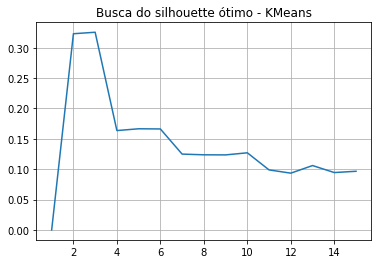

In [26]:
best_cluster("KMeans",p, 15)

Outra forma de avaliação para o número de clusters é a avaliação através do "Método Elbow", que avalia o somatório dos erros quadráticos das instâncias de cada cluster. Neste método, podemos observar que o número de clusters ideais também sugere k=3.

1 217035.0
2 153398.51206191388
3 122310.96624784307
4 112485.80342352523
5 104316.40902498196
6 97216.98017841746
7 93391.90166154955
8 89965.90732436308
9 86831.79488034916
10 84315.54824675532
11 82496.97094903399
12 80519.13215228643
13 77911.72896842306
14 75337.1824917744


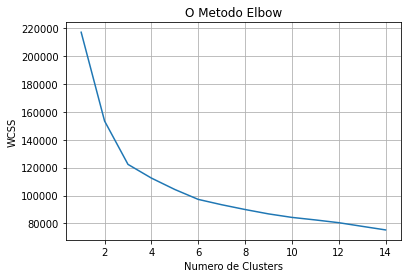

In [27]:
from sklearn.cluster import KMeans
wcss = []
 
for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, random_state=10)
    kmeans.fit(p)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 15), wcss)
plt.title('O Metodo Elbow')
plt.grid()
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS')
plt.show()

### 3.1.2 - Número de Clusters: Clustering Hierárquico

Outra abordagem é a utilização de algoritmos de clustering hierárquico. Neste trabalho utilizou-se a abordagem aglomerativa com o critério "Ward", que minimiza a variância dos clusters mesclados. 
Ao aplicarmos a otimização de hiperparâmetros de acordo com a métrica silhouette, verificou-se que o número de clusters ótimo é 3.

Ward  - Número de clusters ideais considerando a métrica silhouette:  3


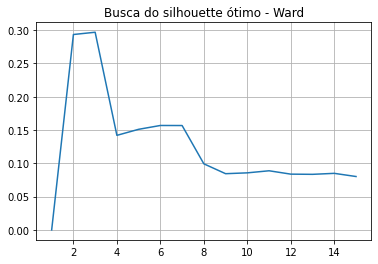

In [28]:
best_cluster("Ward",p, 15)

## 3.2. Aplicação do K-Means para dados padronizados

Com as avaliações no item 3.1.1, foi identificado que o número de clusters ideais para aplicação do KMeans neste dataset é 3.

In [29]:
kmeans = KMeans(n_clusters = 3, random_state=10)

kmeans.fit(p)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=10, tol=0.0001, verbose=0)

In [30]:
distance = kmeans.fit_transform(p)

In [31]:
labels = kmeans.labels_
pl=labels
pl

array([0, 1, 1, ..., 0, 1, 1], dtype=int32)

Observando o resultado do algoritmo, temos que somente duas instâncias foram agrupadas no cluster 2:

In [32]:
df_kmeans=df.copy()
df_kmeans['Cluster']=pd.Series(pl).values
df_kmeans['Cluster'].value_counts()

1    3141
0    2422
2       2
Name: Cluster, dtype: int64

As duas instâncias que foram agrupadas no cluster 2 foram Rio de Janeiro e São Paulo:

In [33]:
df_kmeans[df_kmeans['Cluster']==2][['UF','NOMEMUN','Cluster']]

,UF,NOMEMUN,Cluster
ID,,,
3304557,RJ,RIO DE JANEIRO,2
3550308,SP,SÃO PAULO,2


Podemos observar tambem que regiões Norte e Nordeste possuem a maioria dos seus municípios classificados como Cluster 0, enquanto que nas demais regiões, a maioria dos municipios foi classificada como Cluster 1

In [34]:
df_kmeans[['REGIAO','Cluster','NOMEMUN']].groupby(['REGIAO','Cluster']).count()

NOMEMUN
REGIAO       Cluster         
Centro-Oeste 0             52
             1            336
Nordeste     0           1709
             1             85
Norte        0            384
             1             65
Sudeste      0            230
             1           1436
             2              2
Sul          0             47
             1           1219

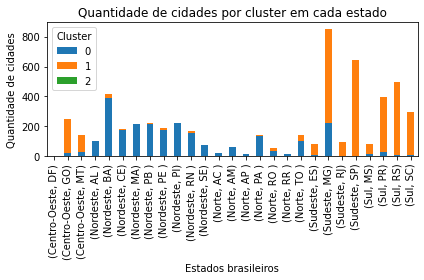

In [35]:
df_kmeans.groupby(['REGIAO','UF','Cluster']).size().unstack().plot(kind='bar',stacked=True)
plt.title('Quantidade de cidades por cluster em cada estado')
plt.ylabel('Quantidade de cidades')
plt.xlabel('Estados brasileiros')
plt.tight_layout()
plt.show()

Aplicação do PCA para redução de dimensionalidade e visualização dos dados:

In [36]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
P=pca.fit_transform(p)

print('Soma da variância acumulada:{}'.format(pca.explained_variance_ratio_ .sum()))
P

Soma da variância acumulada:0.593412446115


array([[-1.3092625 ,  0.16155623],
       [ 1.20011933,  0.70616175],
       [-0.39124023, -0.41752921],
       ...,
       [-0.63817632, -0.28689916],
       [-0.45012564, -0.54959056],
       [10.55567959, 27.92197407]])

Com a redução da dimensionalidade para n=2, temos uma variância acumulada de aproximadamente 60% dos dados. Para uma representação melhor, precisariamos de um n maior mas não seria interessante para observação gráfica.

In [37]:
df_k_pca=pd.DataFrame(P, columns=['PC1', 'PC2'])
df_k_pca['Cluster']=pl
df_k_pca['Cidade']=df_kmeans['NOMEMUN'].values
df_k_pca

,PC1,PC2,Cluster,Cidade
0,-1.309263,0.161556,0,ALTA FLORESTA D'OESTE
1,1.200119,0.706162,1,ARIQUEMES
2,-0.391240,-0.417529,1,CABIXI
3,2.246366,0.442749,1,CACOAL
4,1.434653,-0.574515,1,CEREJEIRAS
...,...,...,...,...
5560,2.692804,-0.874399,1,VIANÓPOLIS
5561,2.434440,-0.748602,1,VICENTINÓPOLIS
5562,-0.638176,-0.286899,0,VILA BOA
5563,-0.450126,-0.549591,1,VILA PROPÍCIO


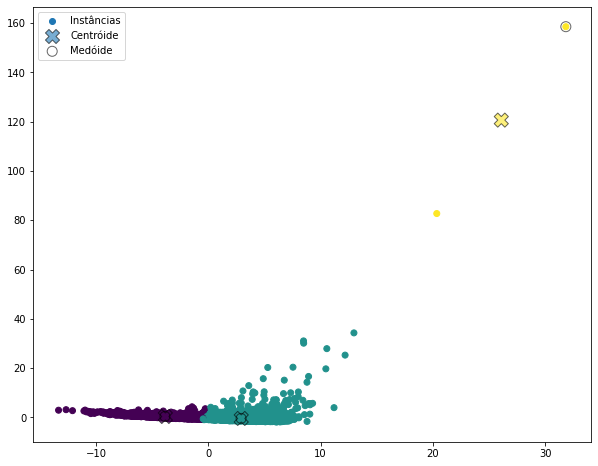

In [38]:
from sklearn import cluster, metrics

kmeans.fit(P)

kmeans.cluster_medoids_=[]

medians_index, _ = metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_ , P[:,:2])

medians_index #array com os indices das instancias dos clusters

for m in medians_index:
    kmeans.cluster_medoids_.append(np.array( [P[m,0],P[m,1]] ))

kmeans.cluster_medoids_

labels=kmeans.labels_
centers=kmeans.cluster_centers_
medoids=np.array(kmeans.cluster_medoids_)


plt.figure(figsize=(10,8))


plt.scatter(P[:,0],P[:,1], c=labels, label="Instâncias")


plt.scatter(centers[:,0],centers[:,1], marker='X', c=np.unique(labels),s=200, ec='k', alpha=0.6, label='Centróide')
plt.scatter(medoids[:,0],medoids[:,1], marker='o', c="None",s=100, ec='k', alpha=0.6, label="Medóide")

plt.legend()

Identificando os medóides de cada cluster, temos as cidades de AQUIDABÃ (Sergipe), Conceição das Alagoas (MG) e São Paulo (SP), como instâncias mais próximas dos clusters 0, 1, 2 respectivamente.

In [39]:
df_k_pca[df_k_pca['PC1'].isin(medoids[:,0])]

,PC1,PC2,Cluster,Cidade
1752,-3.858694,0.424743,0,AQUIDABÃ
2432,2.923431,-0.370503,1,Conceição das Alagoas
3828,31.837228,158.471707,2,SÃO PAULO


Além disso, podemos verificar os principais atributos em cada Componente:

In [40]:
a={key:[x,y] for key,x,y in zip(colunas,pca.components_[0],pca.components_[1])}

rank_pc1 = [(colunas, pca_components_[0]) for colunas, pca_components_ in sorted(a.items(), 
                                                                                 key=lambda x: abs(x[1][0]), reverse=True)]

rank_pc2 = [(colunas, pca_components_[1]) for colunas, pca_components_ in sorted(a.items(), 
                                                                                 key=lambda x: abs(x[1][1]), reverse=True)]

In [41]:
for i in range(4):
    print("PC1 - Atributo",i+1,":",rank_pc1 [:4][i])

print('-'*60)

for i in range(4):
    print("PC2 - Atributo",i+1,":",rank_pc2 [:4][i])

PC1 - Atributo 1 : ('IDHM', 0.2485267318285839)
PC1 - Atributo 2 : ('PPOB', -0.24840113745970227)
PC1 - Atributo 3 : ('PMPOB', -0.24701777816919993)
PC1 - Atributo 4 : ('IDHM_R', 0.24524833357225043)
------------------------------------------------------------
PC2 - Atributo 1 : ('HOMEMTOT', 0.3399468545004039)
PC2 - Atributo 2 : ('TPM', 0.33988219212258725)
PC2 - Atributo 3 : ('MULHERTOT', 0.3397811295069462)
PC2 - Atributo 4 : ('PEA', 0.33899148205813007)


## 3.3. - Aplicação de Clustering Hierárquico em dados padronizados: Ward

In [42]:
from sklearn.cluster import AgglomerativeClustering

In [43]:
w=AgglomerativeClustering(n_clusters=3, linkage='ward')

w.fit_predict(p)

labels_ward=w.labels_

In [44]:
df_ward=df_p.copy()
df_ward['Cluster']=pd.Series(labels_ward).values
df_ward['Cluster'].value_counts()

0    3816
1    1747
2       2
Name: Cluster, dtype: int64

In [45]:
df_ward['Cidade']=df['NOMEMUN']
df_ward['Cidade'][df_ward['Cluster']==2]

ID
3304557    RIO DE JANEIRO
3550308         SÃO PAULO
Name: Cidade, dtype: object

In [46]:
df_ward_pca=pd.DataFrame(P, columns=['PC1', 'PC2'])
df_ward_pca['Cluster']=df_ward['Cluster'].values
df_ward_pca['Cidade']=df_ward['Cidade'].values
df_ward_pca

,PC1,PC2,Cluster,Cidade
0,-1.309263,0.161556,0,ALTA FLORESTA D'OESTE
1,1.200119,0.706162,0,ARIQUEMES
2,-0.391240,-0.417529,0,CABIXI
3,2.246366,0.442749,0,CACOAL
4,1.434653,-0.574515,0,CEREJEIRAS
...,...,...,...,...
5560,2.692804,-0.874399,0,VIANÓPOLIS
5561,2.434440,-0.748602,0,VICENTINÓPOLIS
5562,-0.638176,-0.286899,0,VILA BOA
5563,-0.450126,-0.549591,0,VILA PROPÍCIO


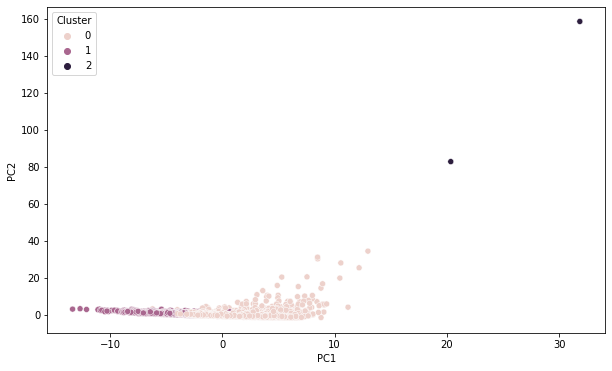

In [47]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_ward_pca['PC1'], y=df_ward_pca['PC2'], hue=df_ward_pca['Cluster'])

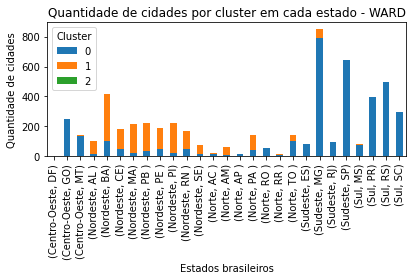

In [48]:
df_ward['REGIAO']=df['REGIAO']
df_ward['UF']=df['UF']
df_ward.groupby(['REGIAO','UF','Cluster']).size().unstack().plot(kind='bar',stacked=True)
plt.title('Quantidade de cidades por cluster em cada estado - WARD')
plt.ylabel('Quantidade de cidades')
plt.xlabel('Estados brasileiros')
plt.tight_layout()
plt.show()

In [49]:
df_ward[['REGIAO','Cluster','Cidade']].groupby(['REGIAO','Cluster']).count()

Cidade
REGIAO       Cluster        
Centro-Oeste 0           381
             1             7
Nordeste     0           338
             1          1456
Norte        0           229
             1           220
Sudeste      0          1607
             1            59
             2             2
Sul          0          1261
             1             5

In [50]:
df_ward.columns

Index(['SCO', 'TPM', 'DDM', 'SMM', 'POM', 'TPO', 'RSA', 'TXE', 'IDEBI',
       'IDEBF', 'PIB', 'RER', 'DEM', 'AUT', 'ESA', 'AVP', 'UVP', 'ESPVIDA',
       'T_ENV', 'E_ANOSESTUDO', 'T_ANALF15M', 'GINI', 'PIND', 'PMPOB', 'PPOB',
       'RDPC', 'T_AGUA', 'T_DENS', 'T_LIXO', 'T_LUZ', 'HOMEMTOT', 'MULHERTOT',
       'PEA', 'pesoRUR', 'pesourb', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R',
       'Cluster', 'Cidade', 'REGIAO', 'UF'],
      dtype='object')

# 4 - Clusterização e o Indice de igualdade de gênero

A partir dos modelos aplicados, verificamos a relação com os valores do score de igualdade de gênero "SCO", original do dataset para analisarmos os resultados

In [51]:
df_final=df[['COD_UF', 'UF', 'REGIAO', 'NOMEMUN', 'SCO']].copy()

In [52]:
df_final['CLUSTER_KMEANS']=df_kmeans['Cluster']
df_final['CLUSTER_HIERARQ']=df_ward['Cluster']
df_final

,COD_UF,UF,REGIAO,NOMEMUN,SCO,CLUSTER_KMEANS,CLUSTER_HIERARQ
ID,,,,,,,
1100015,11,RO,Norte,ALTA FLORESTA D'OESTE,0.707630,0,0
1100023,11,RO,Norte,ARIQUEMES,0.751337,1,0
1100031,11,RO,Norte,CABIXI,0.755332,1,0
1100049,11,RO,Norte,CACOAL,0.751092,1,0
1100056,11,RO,Norte,CEREJEIRAS,0.750303,1,0
...,...,...,...,...,...,...,...
5222005,52,GO,Centro-Oeste,VIANÓPOLIS,0.736929,1,0
5222054,52,GO,Centro-Oeste,VICENTINÓPOLIS,0.758423,1,0
5222203,52,GO,Centro-Oeste,VILA BOA,0.746885,0,0


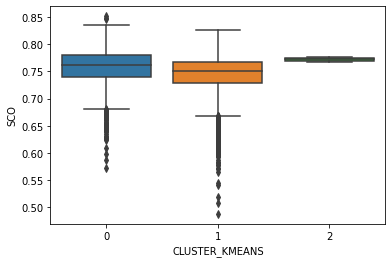

In [53]:
sns.boxplot(x=df_final['CLUSTER_KMEANS'],y=df_final['SCO'])

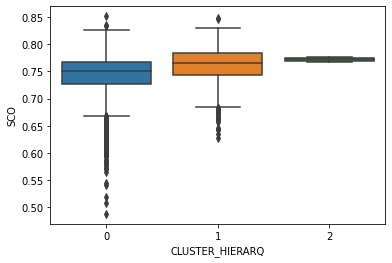

In [54]:
sns.boxplot(x=df_final['CLUSTER_HIERARQ'],y=df_final['SCO'])